In [2]:
from PIL import Image
from PIL import ImageDraw
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [12]:
# ローパスフィルタとハイパスフィルタの両方をかけて、特定の周波数だけのパワースペクトルを出力します。
def SpectrumCritical(filename, ellipse_r_L, ellipse_r_S):
    """
        filename : 元画像
        ellipse_r_L : 外側の半径
        ellipse_r_S : 内側の半径
    """
    # 画像を読み込む
    img = Image.open(filename)
    # グレイスケールに変換する
    gray_img = img.convert('L')
    # NumPy 配列にする
    f_xy = np.asarray(gray_img)

    # 2 次元高速フーリエ変換で周波数領域の情報を取り出す
    f_uv = np.fft.fft2(f_xy)
    # 画像の中心に低周波数の成分がくるように並べかえる
    shifted_f_uv = np.fft.fftshift(f_uv)

    ########################
    
    # フィルタ (ローパス) を用意する
    x_lowpass_filter = Image.new(mode='L',  # 8-bit pixels, black and white
                              size=(shifted_f_uv.shape[0],
                                    shifted_f_uv.shape[1]),
                              color=0,  # default black
                              )
    # 中心に円を描く
    draw = ImageDraw.Draw(x_lowpass_filter)
    # 円の半径  ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
#     ellipse_r_L = 10
    #  ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
    # 画像の中心
    center = (shifted_f_uv.shape[0] // 2,
              shifted_f_uv.shape[1] // 2)
    # 円の座標
    ellipse_pos = (center[0] - ellipse_r_L,
                   center[1] - ellipse_r_L,
                   center[0] + ellipse_r_L,
                   center[1] + ellipse_r_L)
    draw.ellipse(ellipse_pos, fill=255)
    # フィルタ
    lowfilter_array = np.asarray(x_lowpass_filter)

    # フィルタを適用する
    lowfiltered_f_uv = np.multiply(shifted_f_uv, lowfilter_array)
    
    ########################
    
    # フィルタ (ハイパス) を用意する
    x_highpass_filter = Image.new(mode='L',  # 8-bit pixels, black and white
                              size=(shifted_f_uv.shape[0],
                                    shifted_f_uv.shape[1]),
                              color=255,  # default white
                              )
    # 中心に円を描く
    draw = ImageDraw.Draw(x_highpass_filter)
    # 円の半径  ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
#     ellipse_r_S =5
    #  ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
    # 画像の中心
    center = (shifted_f_uv.shape[0] // 2,
              shifted_f_uv.shape[1] // 2)
    # 円の座標
    ellipse_pos = (center[0] - ellipse_r_S,
                   center[1] - ellipse_r_S,
                   center[0] + ellipse_r_S,
                   center[1] + ellipse_r_S)
    draw.ellipse(ellipse_pos, fill=0)
    # フィルタ
    highfilter_array = np.asarray(x_highpass_filter)

    # フィルタを適用する
    filtered_f_uv = np.multiply(lowfiltered_f_uv, highfilter_array)

    # パワースペクトルに変換する
    magnitude_spectrum2d = 20 * np.log(np.absolute(filtered_f_uv))

    # 元の並びに直す
    unshifted_f_uv = np.fft.fftshift(filtered_f_uv)
    # 2 次元逆高速フーリエ変換で空間領域の情報に戻す
    i_f_xy = np.fft.ifft2(unshifted_f_uv).real  # 実数部だけ使う

    # 上記を画像として可視化する
    fig, axes = plt.subplots(1, 4, figsize=(12, 4))
    # 枠線と目盛りを消す
    for ax in axes:
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
    # 元画像
    axes[0].imshow(f_xy, cmap='gray')
    axes[0].set_title('Input Image')
    # フィルタ画像
#     axes[1].imshow(highfilter_array, cmap='gray')
#     axes[1].set_title('Filter Image')
    # フィルタされた周波数領域のパワースペクトル
    axes[2].imshow(magnitude_spectrum2d, cmap='gray')
    axes[2].set_title('Filtered Magnitude Spectrum')
    # FFT -> Band-pass Filter -> IFFT した画像
    axes[3].imshow(i_f_xy, cmap='gray')
    axes[3].set_title('Reversed Image')
    # グラフを表示する
    plt.show()
    
#     print(type(magnitude_spectrum2d))
#     np.histogram(magnitude_spectrum2d)
    x=magnitude_spectrum2d.reshape(1,-1)
    x_data= pd.DataFrame(x)
    df= x_data.replace([np.inf, -np.inf], np.nan)
    
#     print(df)
    gyo=np.array(df)[0]
#     print(type(gyo))
#     plt.hist(df)
    
#     magnitude_spectrum2d_inf = np.where(magnitude_spectrum2d < 0 , 0, magnitude_spectrum2d)
#     print(magnitude_spectrum2d_inf)
    
#     np.histogram(np.array(df))
#     print(np.sum(magnitude_spectrum2d_inf))
    
#     img = np.asarray(magnitude_spectrum2d_inf).reshape(-1,1) 

#     print("start")
#     plt.hist(np.asarray(df).reshape(-1,1),bins=128)
#     print(np.nansum(gyo))
#     plt.show()
#     print("end")

#     import matplotlib
#     matplotlib.image.imsave('name.png', i_f_xy)


/Users/okadamasayuki/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in log


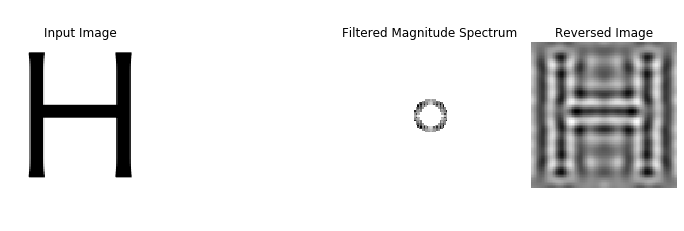

In [13]:
SpectrumCritical('H.png',10,6)

In [14]:
!git init

Initialized empty Git repository in /Users/okadamasayuki/修論実験/.git/


In [29]:
!git add SpectrumLowpass.ipynb
!git commit -m "add SpectrumLowpass"
!git push origin master

[master af1a616] add SpectrumLowpass
 1 file changed, 152 insertions(+)
 create mode 100644 SpectrumLowpass.ipynb
Enumerating objects: 4, done.
Counting objects: 100% (4/4), done.
Delta compression using up to 4 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 17.84 KiB | 8.92 MiB/s, done.
Total 3 (delta 0), reused 0 (delta 0)
To https://github.com/okadamasayuki/-.git
   4b9e98d..af1a616  master -> master


In [26]:
!git commit -m "first comment"

[master (root-commit) 4b9e98d] first comment
 1 file changed, 360 insertions(+)
 create mode 100644 SpectrumCritical.ipynb


In [27]:
!git remote add origin https://github.com/okadamasayuki/-.git

fatal: remote origin already exists.


In [28]:
!git push origin master

Enumerating objects: 3, done.
Counting objects: 100% (3/3), done.
Delta compression using up to 4 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 22.92 KiB | 11.46 MiB/s, done.
Total 3 (delta 0), reused 0 (delta 0)
To https://github.com/okadamasayuki/-.git
 * [new branch]      master -> master


In [22]:
!git branch

In [23]:
!git status

On branch master

No commits yet

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	.ipynb_checkpoints/
	H.png
	PhaseChange.ipynb
	SpectrumCritical.ipynb
	SpectrumHighpass.ipynb
	SpectrumLowpass.ipynb
	Untitled2.ipynb
	Untitled3.ipynb
	Untitled4.ipynb
	"after_\343\202\261\343\202\267\343\203\235\343\203\263.png"
	google.png
	gray_h.png
	h_2-3.png
	h_2-5.png
	h_5-10.png
	high.png
	low.png
	medium.png
	notion_input.png
	notion_reverse.png
	numpy_image_mask.jpg
	numpy_image_mask.png
	out.png
	sample.jpg
	test.jpg
	test.pdf
	test.png
	text.csv
	very high.png
	very low.png
	"\343\201\227\343\201\276\343\201\227\343\201\276.png"
	"\343\202\242\343\203\251\343\203\274\343\203\240.mp3"
	"\343\202\261\343\202\267\343\203\235\343\203\263.png"
	"\343\202\261\343\202\267\343\203\235\343\203\263_2-3.png"
	"\343\202\261\343\202\267\343\203\235\343\203\263_2-5.png"
	"\343\202\261\343\202\267\343\203\235\343\203\263_5-10.png"
	"\343\202\261\343\202\267\343\203\235\343